In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import zipfile
import os
import pickle

# Store data using named keys
def load_eora_data_dict(year):
    print(f'Loading Eora data for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        data = {
            'Eora_pp_T': pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None),
            'Eora_pp_FD': pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None),
            'Eora_pp_VA': pd.read_csv(z.open(f'Eora26_{year}_bp_VA.txt'), sep='\t', header=None),
            'Eora_pp_Q': pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None),
            'Eora_pp_QY': pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None),
            'labels_T': pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None),
            'labels_FD': pd.read_csv(z.open('labels_FD.txt'), sep='\t', header=None),
            'labels_VA': pd.read_csv(z.open('labels_VA.txt'), sep='\t', header=None),
            'labels_Q': pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
        }
    return data

def load_sectorial_variables(year, save_path):
    print(f'Loading sectoral variables for the year {year}')
    file_name = f"sectoral_variables_{year}.pkl"
    file_path = os.path.join(save_path, file_name)
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the data for all years from 1990 to 2015
eora_dict = {}
for year in range(1990, 2016):
    eora_dict[year] = load_eora_data_dict(year)

sectoral_variables = {}
save_path = '/content/drive/MyDrive/Yannis/ABM'
for year in range(1990, 2016):
    sectoral_variables[year] = load_sectorial_variables(year, save_path)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

# Store data using named keys
def load_eora_data_dict(year):
    print(f'Loading Eora data for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        data = {
            'Eora_pp_T': pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None),
            'Eora_pp_FD': pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None),
            'Eora_pp_VA': pd.read_csv(z.open(f'Eora26_{year}_bp_VA.txt'), sep='\t', header=None),
            'Eora_pp_Q': pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None),
            'Eora_pp_QY': pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None),
            'labels_T': pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None),
            'labels_FD': pd.read_csv(z.open('labels_FD.txt'), sep='\t', header=None),
            'labels_VA': pd.read_csv(z.open('labels_VA.txt'), sep='\t', header=None),
            'labels_Q': pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
        }
    return data

# Define the analysis function
def perform_analysis(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    xout = Eora_pp_T_matrix.sum(axis=0) + Eora_pp_FD.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create country-specific sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Calculate direct emission intensity
    direct_emission_intensity = Eora_pp_Q_emissions_matrix.sum(axis=0) / xout

    # Backward indirect emissions
    direct_emission_coeff = np.diag(direct_emission_intensity)
    backward_indirect_emissions = np.dot(direct_emission_coeff, L) - direct_emission_coeff
    total_backward_indirect_emissions = backward_indirect_emissions.sum(axis=0)

    # Calculate the Ghosh Inverse Matrix
    B = Eora_pp_T_matrix / Eora_pp_T_matrix.sum(axis=1, keepdims=True)
    G = np.linalg.inv(np.eye(B.shape[0]) - B)

    # Forward indirect emissions
    forward_indirect_emissions = np.dot(G, direct_emission_coeff) - direct_emission_coeff
    total_forward_indirect_emissions = forward_indirect_emissions.sum(axis=1)

    # Compile results into a DataFrame for analysis
    results = pd.DataFrame({
        'Country_Sector': country_sector_labels,
        'Direct_Emission_Intensity': direct_emission_intensity,
        'Total_Backward_Indirect_Emissions': total_backward_indirect_emissions,
        'Total_Forward_Indirect_Emissions': total_forward_indirect_emissions
    })

    # Determine potential sunset industries based on the threshold
    threshold = results['Direct_Emission_Intensity'].quantile(0.75)  # Example threshold, can be adjusted
    sunset_industries = results[
        (results['Direct_Emission_Intensity'] > threshold) |
        (results['Total_Backward_Indirect_Emissions'] > threshold) |
        (results['Total_Forward_Indirect_Emissions'] > threshold)
    ]

    return results, sunset_industries

# Example usage
year = 2015
results, sunset_industries = perform_analysis(year)
print(sunset_industries)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: operands could not be broadcast together with shapes (4915,) (1140,) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import pandas as pd

def extract_Eora26_data(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    return Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q

Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q = extract_Eora26_data(1990)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

# Store data using named keys
def load_eora_data_dict(year):
    print(f'Loading Eora data for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        data = {
            'Eora_pp_T': pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None),
            'Eora_pp_FD': pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None),
            'Eora_pp_VA': pd.read_csv(z.open(f'Eora26_{year}_bp_VA.txt'), sep='\t', header=None),
            'Eora_pp_Q': pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None),
            'Eora_pp_QY': pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None),
            'labels_T': pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None),
            'labels_FD': pd.read_csv(z.open('labels_FD.txt'), sep='\t', header=None),
            'labels_VA': pd.read_csv(z.open('labels_VA.txt'), sep='\t', header=None),
            'labels_Q': pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
        }
    return data

# Define the analysis function
def perform_analysis(year):

    eora_dict = load_eora_data_dict(year)

    # Extract the specific DataFrames from the dictionary
    Eora_pp_T = eora_dict['Eora_pp_T']
    Eora_pp_FD = eora_dict['Eora_pp_FD']
    Eora_pp_VA = eora_dict['Eora_pp_VA']
    Eora_pp_Q = eora_dict['Eora_pp_Q']
    labels_T = eora_dict['labels_T']
    labels_Q = eora_dict['labels_Q']
    labels_FD = eora_dict['labels_FD']
    labels_VA = eora_dict['labels_VA']

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create country-specific sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Calculate direct emission intensity
    direct_emission_intensity = Eora_pp_Q_emissions_matrix.sum(axis=0) / xout

    # Backward indirect emissions
    direct_emission_coeff = np.diag(direct_emission_intensity)
    backward_indirect_emissions = np.dot(direct_emission_coeff, L) - direct_emission_coeff
    total_backward_indirect_emissions = backward_indirect_emissions.sum(axis=0)

    # Calculate the Ghosh Inverse Matrix
    row_sums = Eora_pp_T_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-10  # Avoid division by zero
    B = Eora_pp_T_matrix / row_sums
    G = np.linalg.inv(np.eye(B.shape[0]) - B)

    # Forward indirect emissions
    forward_indirect_emissions = np.dot(G, direct_emission_coeff) - direct_emission_coeff
    total_forward_indirect_emissions = forward_indirect_emissions.sum(axis=1)

    # Compile results into a DataFrame for analysis
    results = pd.DataFrame({
        'Country_Sector': country_sector_labels,
        'Direct_Emission_Intensity': direct_emission_intensity,
        'Total_Backward_Indirect_Emissions': total_backward_indirect_emissions,
        'Total_Forward_Indirect_Emissions': total_forward_indirect_emissions
    })

    # Determine potential sunset industries based on the threshold
    threshold_sunset = results['Direct_Emission_Intensity'].quantile(0.90)  # Example threshold, can be adjusted
    threshold_sunrise = results['Direct_Emission_Intensity'].quantile(0.10)  # Example threshold, can be adjusted
    sunset_industries = results[
        (results['Direct_Emission_Intensity'] > threshold_sunset) &
        (results['Total_Backward_Indirect_Emissions'] > threshold_sunset) &
        (results['Total_Forward_Indirect_Emissions'] > threshold_sunset)
    ]
    sunrise_industries = results[
        (results['Direct_Emission_Intensity'] < threshold_sunrise) |
        (results['Total_Backward_Indirect_Emissions'] < threshold_sunrise) |
        (results['Total_Forward_Indirect_Emissions'] < threshold_sunrise)
    ]

    return results, sunset_industries, sunrise_industries

# Example usage
year = 2015
results, sunset_industries, sunrise_industries = perform_analysis(year)
print('n\ Sunset Industries n\:' , sunset_industries['Country_Sector'].unique())
print('n\ Sunrise Industries n\:' , sunrise_industries['Country_Sector'].unique())

Mounted at /content/drive
Loading Eora data for the year 2015
n\ Sunset Industries n\: ['AFG_Agriculture' 'ALB_Mining and Quarrying'
 'ALB_Electricity, Gas and Water' 'AGO_Agriculture'
 'AGO_Electricity, Gas and Water' 'ATG_Fishing'
 'ATG_Electricity, Gas and Water' 'ARM_Electricity, Gas and Water'
 'ABW_Agriculture' 'ABW_Fishing' 'ABW_Electricity, Gas and Water'
 'ABW_Others' 'AZE_Electricity, Gas and Water'
 'BHS_Electricity, Gas and Water' 'BHR_Electricity, Gas and Water'
 'BGD_Agriculture' 'BRB_Electricity, Gas and Water' 'BLR_Agriculture'
 'BLR_Fishing' 'BLR_Mining and Quarrying' 'BLR_Food & Beverages'
 'BLR_Wood and Paper'
 'BLR_Petroleum, Chemical and Non-Metallic Mineral Products'
 'BLR_Metal Products' 'BLR_Other Manufacturing'
 'BLR_Electricity, Gas and Water' 'BLR_Construction'
 'BLR_Maintenance and Repair' 'BLR_Wholesale Trade' 'BLR_Retail Trade'
 'BLR_Hotels and Restraurants' 'BLR_Transport'
 'BLR_Post and Telecommunications'
 'BLR_Finacial Intermediation and Business Activ

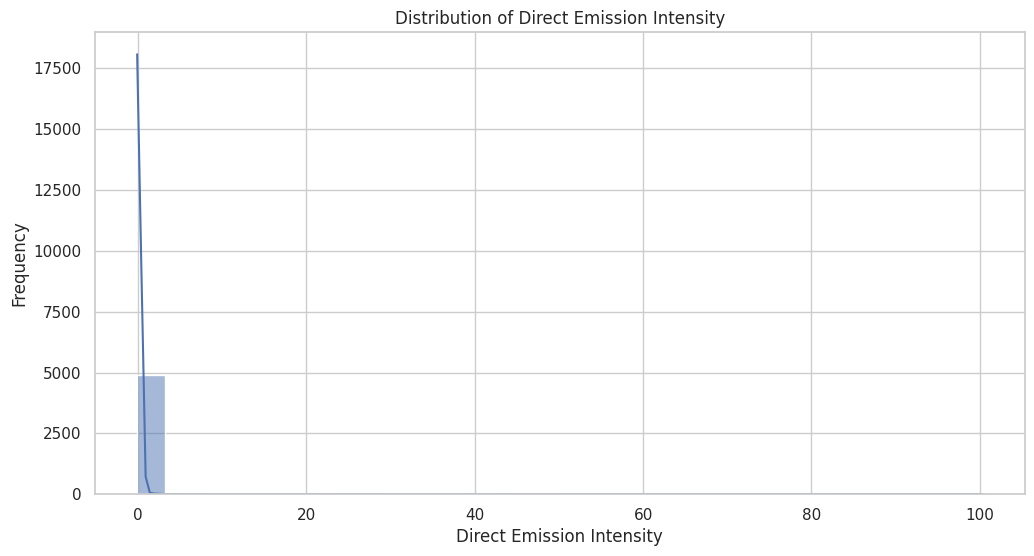

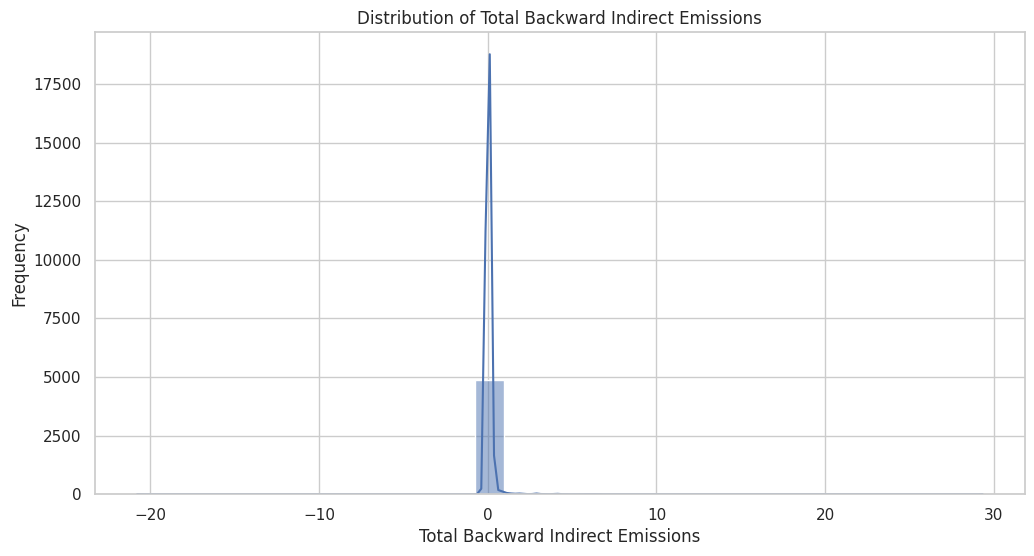

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot histogram for Direct Emission Intensity
plt.figure(figsize=(12, 6))
sns.histplot(results['Direct_Emission_Intensity'], bins=30, kde=True)
plt.title('Distribution of Direct Emission Intensity')
plt.xlabel('Direct Emission Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Backward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(results['Total_Backward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Backward Indirect Emissions')
plt.xlabel('Total Backward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Forward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(results['Total_Forward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Forward Indirect Emissions')
plt.xlabel('Total Forward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()


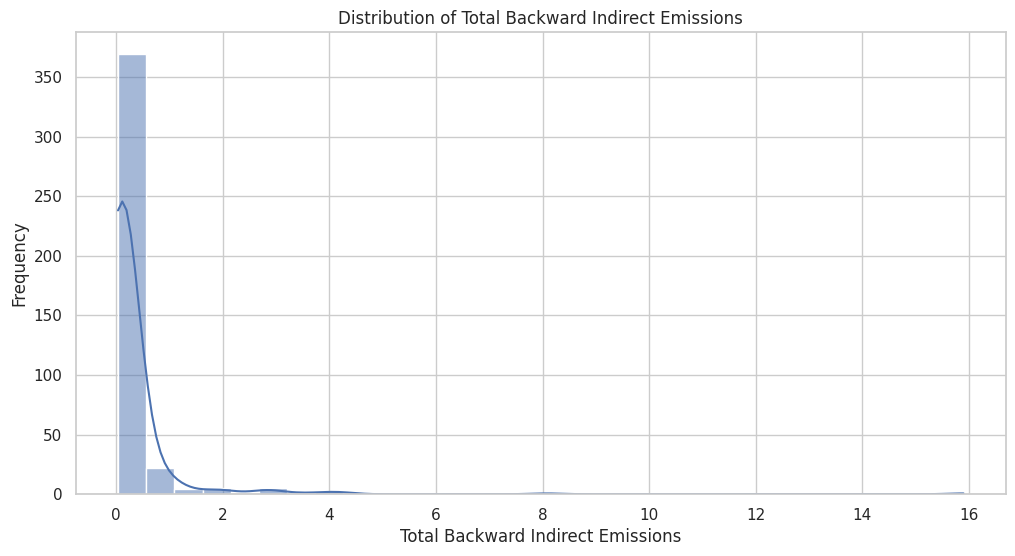

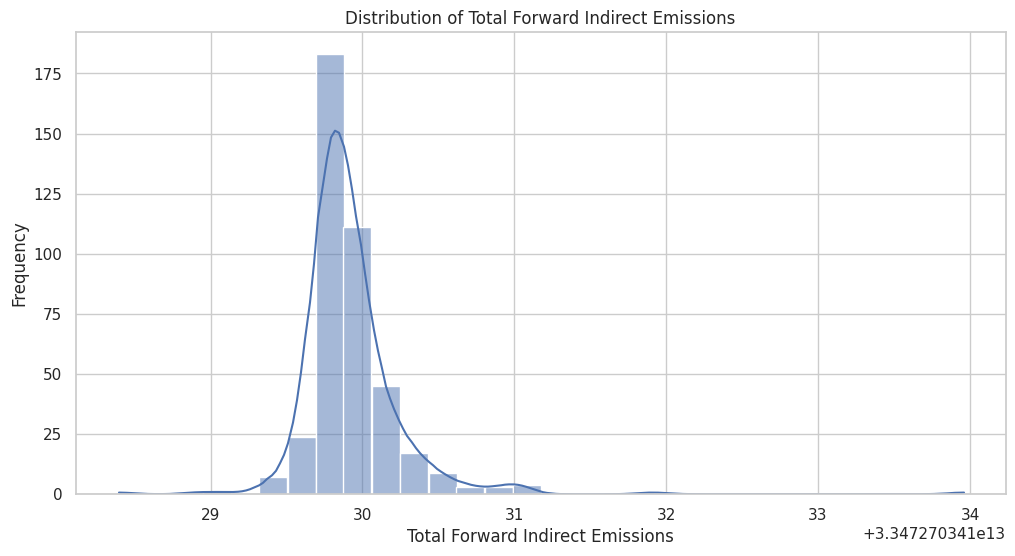

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot histogram for Direct Emission Intensity
plt.figure(figsize=(12, 6))
sns.histplot(sunset_industries['Direct_Emission_Intensity'], bins=30, kde=True)
plt.title('Distribution of Direct Emission Intensity')
plt.xlabel('Direct Emission Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Backward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(sunset_industries['Total_Backward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Backward Indirect Emissions')
plt.xlabel('Total Backward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Forward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(sunset_industries['Total_Forward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Forward Indirect Emissions')
plt.xlabel('Total Forward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()


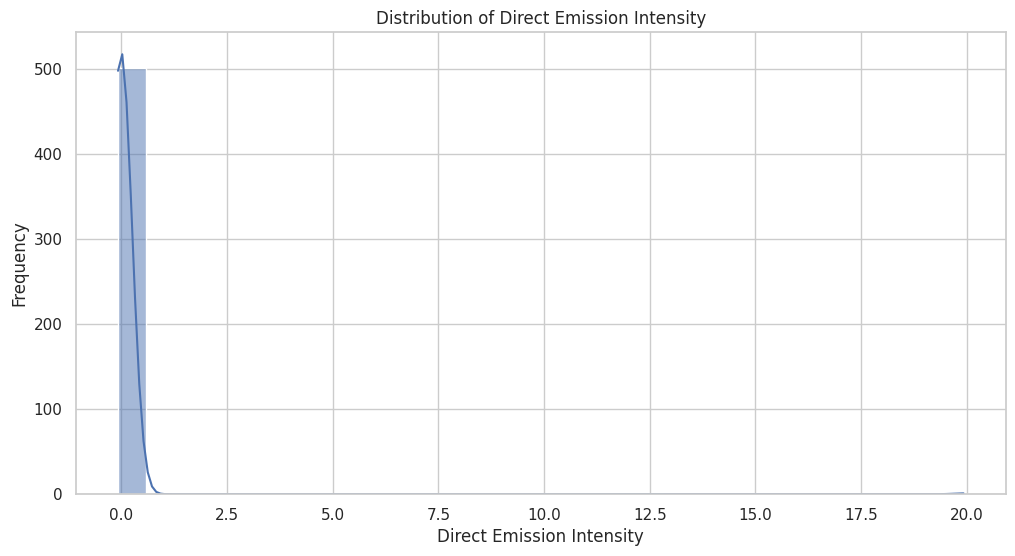

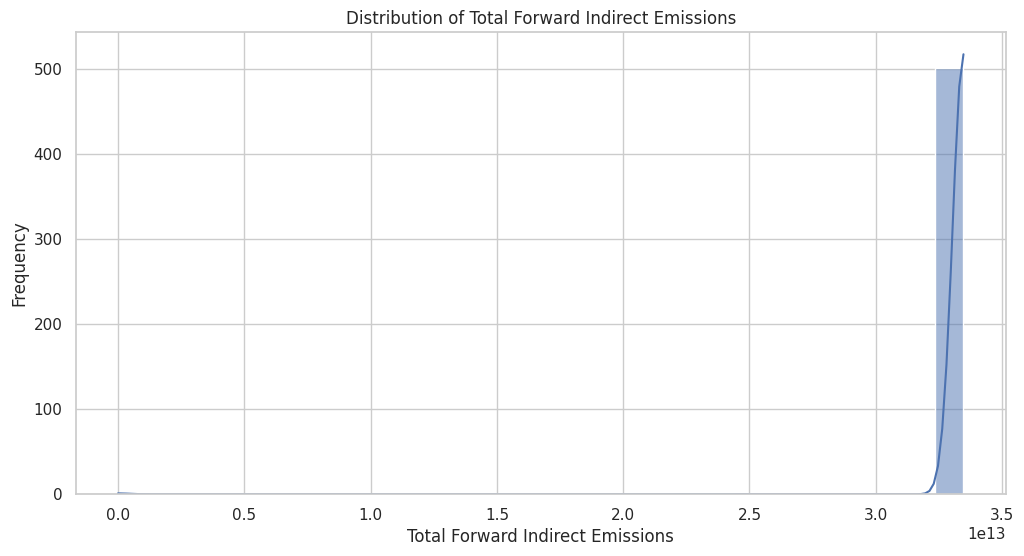

In [36]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plot histogram for Direct Emission Intensity
plt.figure(figsize=(12, 6))
sns.histplot(sunrise_industries['Direct_Emission_Intensity'], bins=30, kde=True)
plt.title('Distribution of Direct Emission Intensity')
plt.xlabel('Direct Emission Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Backward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(sunrise_industries['Total_Backward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Backward Indirect Emissions')
plt.xlabel('Total Backward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Total Forward Indirect Emissions
plt.figure(figsize=(12, 6))
sns.histplot(sunrise_industries['Total_Forward_Indirect_Emissions'], bins=30, kde=True)
plt.title('Distribution of Total Forward Indirect Emissions')
plt.xlabel('Total Forward Indirect Emissions')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Filter the DataFrame where 'Country_sector' equals 'Kor_Recycling'
sunrise_industries.head(100)


Country_Sector  Direct_Emission_Intensity  \
13                            AFG_Construction                   0.000204   
21                   AFG_Public Administration                   0.000256   
25                   AFG_Re-export & Re-import                   0.000257   
39                            ALB_Construction                   0.000227   
51                   ALB_Re-export & Re-import                   0.000113   
...                                        ...                        ...   
1135               HRV_Hotels and Restraurants                   0.000227   
1139                 HRV_Public Administration                   0.000179   
1140  HRV_Education, Health and Other Services                   0.000188   
1143                 HRV_Re-export & Re-import                   0.000075   
1160                          CUB_Retail Trade                   0.000261   

      Total_Backward_Indirect_Emissions  Total_Forward_Indirect_Emissions  
13                             0.014827                      3.347270e+13  
21                             0.011816                      3.347270e+13  
25                             0.051566                      3.347270e+13  
39                             0.012819                      3.347270e+13  
51                             0.066261                      3.347270e+13  
...                                 ...                               ...  
1135                           0.009066                      3.347270e+13  
1139                           0.005724                      3.347270e+13  
1140                           0.006119                      3.347270e+13  
1143                           0.078182                      3.347270e+13  
1160                           0.006921                      3.347270e+13  

[100 rows x 4 columns]

from matplotlib import pyplot as plt
_df_0['Direct_Emission_Intensity'].plot(kind='hist', bins=20, title='Direct_Emission_Intensity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Total_Backward_Indirect_Emissions'].plot(kind='hist', bins=20, title='Total_Backward_Indirect_Emissions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Total_Forward_Indirect_Emissions'].plot(kind='hist', bins=20, title='Total_Forward_Indirect_Emissions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Direct_Emission_Intensity', y='Total_Backward_Indirect_Emissions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Total_Backward_Indirect_Emissions', y='Total_Forward_Indirect_Emissions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Direct_Emission_Intensity'].plot(kind='line', figsize=(8, 4), title='Direct_Emission_Intensity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Total_Backward_Indirect_Emissions'].plot(kind='line', figsize=(8, 4), title='Total_Backward_Indirect_Emissions')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Total_Forward_Indirect_Emissions'].plot(kind='line', figsize=(8, 4), title='Total_Forward_Indirect_Emissions')
plt.gca().spines[['top', 'right']].set_visible(False)

In [41]:
from matplotlib import pyplot as plt
_df_0['Direct_Emission_Intensity'].plot(kind='hist', bins=20, title='Direct_Emission_Intensity')
plt.gca().spines[['top', 'right',]].set_visible(False)